In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

# 하이퍼파라미터 튜닝

In [2]:
my_learning_rate = 0.0001
my_epoch = 300
my_batch_size = 256
my_patience = 20
my_class_weight = {0 : 1.0, 1 : 7.0}

# 환경설정

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
import joblib
import matplotlib.pyplot as plt
plt.rc("font",family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 데이터 체크
- 사전 처리된 데이터 인계 : 인사평가_피쳐생성.csv
- data 결측치 0건(전처리 완)

In [4]:
data = pd.read_csv("../data/인사평가_피쳐생성.csv")
data

,나이,출장,참여프로젝트,근속연차,월급,이직회수,업무평가,주변평가,경력,전년도교육출장횟수,...,연봉/프로젝트비율,경력-근속연차,근속연차차이,프로젝트밀도지수,평판×근속연차,연봉×평판점수,경력/나이비율,근속/나이비율,연봉/나이,입사나이
0,41,1~29회,3,2,8090550,8,보통,1,8,0,...,2696850.0,6,-4,0.375000,2,8090550,0.195122,0.048780,197330.487805,33
1,49,30회 이상,2,2,6925500,1,좋다,4,10,3,...,3462750.0,8,-8,0.500000,8,27702000,0.204082,0.040816,141336.734694,39
2,37,1~29회,2,1,2821500,6,보통,2,7,3,...,1410750.0,6,1,0.714286,2,5643000,0.189189,0.027027,76256.756757,30
3,33,30회 이상,3,1,3927150,1,보통,3,8,3,...,1309050.0,7,-7,0.750000,3,11781450,0.242424,0.030303,119004.545455,25
4,27,1~29회,3,1,4681800,9,보통,4,6,3,...,1560600.0,5,-1,1.000000,4,18727200,0.222222,0.037037,173400.000000,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,30회 이상,4,2,3470850,4,보통,3,17,3,...,867712.5,15,-3,0.411765,6,10412550,0.472222,0.055556,96412.500000,19
1466,39,1~29회,2,3,13487850,4,보통,1,9,5,...,6743925.0,6,-4,0.777778,3,13487850,0.230769,0.076923,345842.307692,30
1467,27,1~29회,4,2,8291700,1,좋다,2,6,0,...,2072925.0,4,-4,0.666667,4,16583400,0.222222,0.074074,307100.000000,21
1468,49,30회 이상,2,2,7276500,2,보통,4,17,3,...,3638250.0,15,-7,0.294118,8,29106000,0.346939,0.040816,148500.000000,32


In [5]:
data.info() # 출장, 업무평가 object 타입, 결측치 0건

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   나이         1470 non-null   int64  
 1   출장         1470 non-null   object 
 2   참여프로젝트     1470 non-null   int64  
 3   근속연차       1470 non-null   int64  
 4   월급         1470 non-null   int64  
 5   이직회수       1470 non-null   int64  
 6   업무평가       1470 non-null   object 
 7   주변평가       1470 non-null   int64  
 8   경력         1470 non-null   int64  
 9   전년도교육출장횟수  1470 non-null   int64  
 10  현회사근속년수    1470 non-null   int64  
 11  출장_등급      1470 non-null   int64  
 12  이직률        1470 non-null   float64
 13  프로젝트참여율    1470 non-null   float64
 14  교육출장참여율    1470 non-null   float64
 15  현직근속비율     1470 non-null   float64
 16  연봉/경력비율    1470 non-null   float64
 17  연봉/프로젝트비율  1470 non-null   float64
 18  경력-근속연차    1470 non-null   int64  
 19  근속연차차이     1470 non-null   int64  
 20  프로젝트밀도지수

In [6]:
data.select_dtypes('object').columns

Index(['출장', '업무평가'], dtype='object')

In [7]:
data.describe() # numeric 값만 체크

,나이,참여프로젝트,근속연차,월급,이직회수,주변평가,경력,전년도교육출장횟수,현회사근속년수,출장_등급,...,연봉/프로젝트비율,경력-근속연차,근속연차차이,프로젝트밀도지수,평판×근속연차,연봉×평판점수,경력/나이비율,근속/나이비율,연봉/나이,입사나이
count,1470.000000,1470.000000,1470.000000,1.470000e+03,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1.470000e+03,1470.000000,1470.000000,1470.000000,1470.000000,1.470000e+03,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,2.729932,2.063946,8.778957e+06,2.693197,2.712245,11.279592,2.799320,7.008163,1.086395,...,3.563946e+06,9.215646,-4.944218,0.941390,5.623810,2.398836e+07,0.288007,0.055482,230772.805763,25.644218
std,9.135373,0.711561,1.106940,6.355742e+06,2.498009,1.081209,7.780782,1.289271,6.126525,0.532170,...,3.121243e+06,6.949229,5.613088,1.255813,4.007733,2.131130e+07,0.153429,0.024024,137495.271680,6.875481
min,18.000000,1.000000,1.000000,1.362150e+06,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,3.682125e+05,-1.000000,-37.000000,0.000000,1.000000,1.620000e+06,0.000000,0.016949,48645.000000,18.000000
25%,30.000000,2.000000,1.000000,3.929850e+06,1.000000,2.000000,6.000000,2.000000,3.000000,1.000000,...,1.539338e+06,5.000000,-7.000000,0.333333,3.000000,9.520875e+06,0.181818,0.035714,125834.482759,20.000000
50%,36.000000,3.000000,2.000000,6.640650e+06,2.000000,3.000000,10.000000,3.000000,5.000000,1.000000,...,2.443950e+06,7.000000,-4.000000,0.571429,4.000000,1.656720e+07,0.264706,0.052632,190309.821429,24.000000
75%,43.000000,3.000000,3.000000,1.131165e+07,4.000000,4.000000,15.000000,3.000000,9.000000,1.000000,...,4.540050e+06,13.000000,-1.000000,1.000000,8.000000,3.015934e+07,0.400000,0.071429,301678.969003,30.000000
max,60.000000,4.000000,5.000000,2.699865e+07,9.000000,4.000000,40.000000,6.000000,40.000000,2.000000,...,2.696355e+07,37.000000,5.000000,9.000000,20.000000,1.076922e+08,0.689655,0.137931,750600.000000,56.000000


In [8]:
print(data.select_dtypes('object')['출장'].value_counts())
print("-"*50)
print(data.select_dtypes('object')['업무평가'].value_counts())

1~29회     1043
30회 이상     277
0회         150
Name: 출장, dtype: int64
--------------------------------------------------
보통    1244
좋다     226
Name: 업무평가, dtype: int64


# 데이터 상관계수 및 시각화

## 우선 업무평가, 출장을 라벨링해 전체를 체크 필요
- 업무평가는 0, 1 : 보통과 좋다로 분류되며 서열이 있어 일반 labeling 보다 Ordinal Labeling
- 출장 또한 0회 / 1 ~ 29회 / 30회 이상으로 분류되며 이에 따라서 Ordinal Labeling 필요

In [9]:
def ordinalEncoding(row) : 
    row = row.copy()
    manager_dict = {"보통":0, "좋다":1}
    if row['출장'] == "1~29회" :
        row['출장odm'] = 1
    elif row['출장'] == "30회 이상" :
        row['출장odm'] = 2
    else :
        row['출장odm'] = 0
    row['업무평가odm'] = manager_dict.get(row['업무평가'])
    return row

ordinalEncoding(data.iloc[0]) # ok

나이                      41
출장                   1~29회
참여프로젝트                   3
근속연차                     2
월급                 8090550
이직회수                     8
업무평가                    보통
주변평가                     1
경력                       8
전년도교육출장횟수                0
현회사근속년수                  6
출장_등급                    1
이직률                    1.0
프로젝트참여율              0.375
교육출장참여율                0.0
현직근속비율                0.75
연봉/경력비율         1011318.75
연봉/프로젝트비율        2696850.0
경력-근속연차                  6
근속연차차이                  -4
프로젝트밀도지수             0.375
평판×근속연차                  2
연봉×평판점수            8090550
경력/나이비율           0.195122
근속/나이비율            0.04878
연봉/나이        197330.487805
입사나이                    33
출장odm                    1
업무평가odm                  0
Name: 0, dtype: object

In [10]:
data_odm = data.apply(ordinalEncoding, axis=1)
data_odm

,나이,출장,참여프로젝트,근속연차,월급,이직회수,업무평가,주변평가,경력,전년도교육출장횟수,...,근속연차차이,프로젝트밀도지수,평판×근속연차,연봉×평판점수,경력/나이비율,근속/나이비율,연봉/나이,입사나이,출장odm,업무평가odm
0,41,1~29회,3,2,8090550,8,보통,1,8,0,...,-4,0.375000,2,8090550,0.195122,0.048780,197330.487805,33,1,0
1,49,30회 이상,2,2,6925500,1,좋다,4,10,3,...,-8,0.500000,8,27702000,0.204082,0.040816,141336.734694,39,2,1
2,37,1~29회,2,1,2821500,6,보통,2,7,3,...,1,0.714286,2,5643000,0.189189,0.027027,76256.756757,30,1,0
3,33,30회 이상,3,1,3927150,1,보통,3,8,3,...,-7,0.750000,3,11781450,0.242424,0.030303,119004.545455,25,2,0
4,27,1~29회,3,1,4681800,9,보통,4,6,3,...,-1,1.000000,4,18727200,0.222222,0.037037,173400.000000,21,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,30회 이상,4,2,3470850,4,보통,3,17,3,...,-3,0.411765,6,10412550,0.472222,0.055556,96412.500000,19,2,0
1466,39,1~29회,2,3,13487850,4,보통,1,9,5,...,-4,0.777778,3,13487850,0.230769,0.076923,345842.307692,30,1,0
1467,27,1~29회,4,2,8291700,1,좋다,2,6,0,...,-4,0.666667,4,16583400,0.222222,0.074074,307100.000000,21,1,1
1468,49,30회 이상,2,2,7276500,2,보통,4,17,3,...,-7,0.294118,8,29106000,0.346939,0.040816,148500.000000,32,2,0


### 불필요 컬럼(라벨링 전 컬럼들) 제거

In [11]:
data = data_odm.drop(['출장','업무평가',"출장odm"], axis=1)
data

,나이,참여프로젝트,근속연차,월급,이직회수,주변평가,경력,전년도교육출장횟수,현회사근속년수,출장_등급,...,경력-근속연차,근속연차차이,프로젝트밀도지수,평판×근속연차,연봉×평판점수,경력/나이비율,근속/나이비율,연봉/나이,입사나이,업무평가odm
0,41,3,2,8090550,8,1,8,0,6,1,...,6,-4,0.375000,2,8090550,0.195122,0.048780,197330.487805,33,0
1,49,2,2,6925500,1,4,10,3,10,2,...,8,-8,0.500000,8,27702000,0.204082,0.040816,141336.734694,39,1
2,37,2,1,2821500,6,2,7,3,0,1,...,6,1,0.714286,2,5643000,0.189189,0.027027,76256.756757,30,0
3,33,3,1,3927150,1,3,8,3,8,2,...,7,-7,0.750000,3,11781450,0.242424,0.030303,119004.545455,25,0
4,27,3,1,4681800,9,4,6,3,2,1,...,5,-1,1.000000,4,18727200,0.222222,0.037037,173400.000000,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,4,2,3470850,4,3,17,3,5,2,...,15,-3,0.411765,6,10412550,0.472222,0.055556,96412.500000,19,0
1466,39,2,3,13487850,4,1,9,5,7,1,...,6,-4,0.777778,3,13487850,0.230769,0.076923,345842.307692,30,0
1467,27,4,2,8291700,1,2,6,0,6,1,...,4,-4,0.666667,4,16583400,0.222222,0.074074,307100.000000,21,1
1468,49,2,2,7276500,2,4,17,3,9,2,...,15,-7,0.294118,8,29106000,0.346939,0.040816,148500.000000,32,0


In [12]:
corrs = data.corr(numeric_only=True)

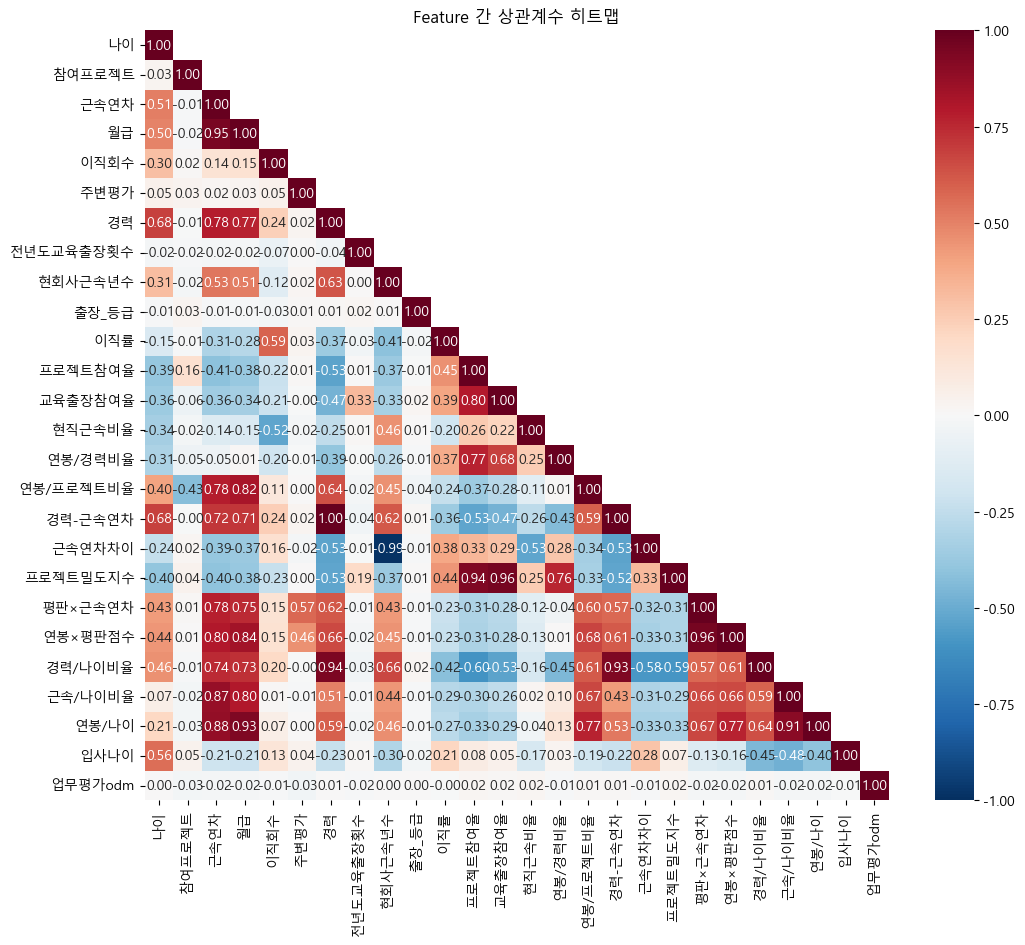

In [13]:
mask = np.triu(np.ones_like(corrs, dtype=bool), k=1)
plt.figure(figsize=(12,10))
sns.heatmap(corrs, annot=True,mask=mask, fmt='.2f', cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Feature 간 상관계수 히트맵')
plt.show()

In [14]:
corrs['업무평가odm']

나이           0.001904
참여프로젝트      -0.029071
근속연차        -0.021222
월급          -0.017120
이직회수        -0.014095
주변평가        -0.031351
경력           0.006744
전년도교육출장횟수   -0.015579
현회사근속년수      0.003435
출장_등급        0.001683
이직률         -0.004408
프로젝트참여율      0.020697
교육출장참여율      0.015005
현직근속비율       0.021166
연봉/경력비율     -0.012695
연봉/프로젝트비율    0.008813
경력-근속연차      0.010931
근속연차차이      -0.007934
프로젝트밀도지수     0.018527
평판×근속연차     -0.021645
연봉×평판점수     -0.017798
경력/나이비율      0.009810
근속/나이비율     -0.019072
연봉/나이       -0.017191
입사나이        -0.005102
업무평가odm      1.000000
Name: 업무평가odm, dtype: float64

### 상관계수는 모두 절대값 0.03 이하로, 선형회귀 형태 분석은 불가에 가까움

# 데이터 분리

In [15]:
# 분리전 X 데이터 스케일 조정
y = data['업무평가odm']
X = data.copy().drop('업무평가odm',axis=1)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[0.54761905, 0.66666667, 0.25      , ..., 0.26310828, 0.21181627,
        0.39473684],
       [0.73809524, 0.33333333, 0.25      , ..., 0.19727891, 0.13204797,
        0.55263158],
       [0.45238095, 0.33333333, 0.        , ..., 0.08330069, 0.03933551,
        0.31578947],
       ...,
       [0.21428571, 1.        , 0.25      , ..., 0.47217749, 0.36819312,
        0.07894737],
       [0.73809524, 0.33333333, 0.25      , ..., 0.19727891, 0.14225271,
        0.36842105],
       [0.38095238, 1.        , 0.25      , ..., 0.34612106, 0.17981168,
        0.26315789]])

In [16]:
from sklearn.model_selection import train_test_split
# train세트 구분
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled,y,stratify=y, train_size=0.7)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1029, 25), (441, 25), (1029,), (441,))

# Model설계

In [17]:
inputs = Input((X_train.shape[1],))
x = Dense(128, activation="relu")(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs = inputs, outputs = outputs)

# 학습설정

In [18]:
from tensorflow.keras.optimizers import Adam
model.compile( 
    optimizer=Adam(learning_rate=my_learning_rate),
    loss='binary_crossentropy',
    metrics=[AUC(name='auc_pr', curve='PR'),
             Precision(name='precision'),
             Recall(name='recall'),
            'accuracy'],
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense (Dense)               (None, 128)               3328      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                             

# 모델 학습

In [19]:
es = EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)
mcp = ModelCheckpoint(filepath="checkpoint/{val_loss}_{precision}.h5",save_best_only=True)

history = model.fit(
    X_train,
    Y_train,
    epochs=my_epoch,
    batch_size=my_batch_size,
    callbacks=[es, rlr, mcp],
    verbose='auto',
    validation_split=0.3,
    class_weight=my_class_weight,
)

Epoch 1/300
3/3 [==============================] - 2s 147ms/step - loss: 1.6193 - auc_pr: 0.1545 - precision: 0.1409 - recall: 0.5204 - accuracy: 0.5028 - val_loss: 0.6479 - val_auc_pr: 0.2365 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.8058 - lr: 1.0000e-04
Epoch 2/300
3/3 [==============================] - 0s 18ms/step - loss: 1.6952 - auc_pr: 0.1607 - precision: 0.1344 - recall: 0.5102 - accuracy: 0.4861 - val_loss: 0.6485 - val_auc_pr: 0.2475 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.8058 - lr: 1.0000e-04
Epoch 3/300
3/3 [==============================] - 0s 21ms/step - loss: 1.6119 - auc_pr: 0.1396 - precision: 0.1325 - recall: 0.5204 - accuracy: 0.4708 - val_loss: 0.6489 - val_auc_pr: 0.2429 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.8058 - lr: 1.0000e-04
Epoch 4/300
3/3 [==============================] - 0s 21ms/step - loss: 1.6216 - auc_pr: 0.1534 - precision: 0.1397 - recall: 0.5204 - accuracy:

# 모델 학습과정 체크

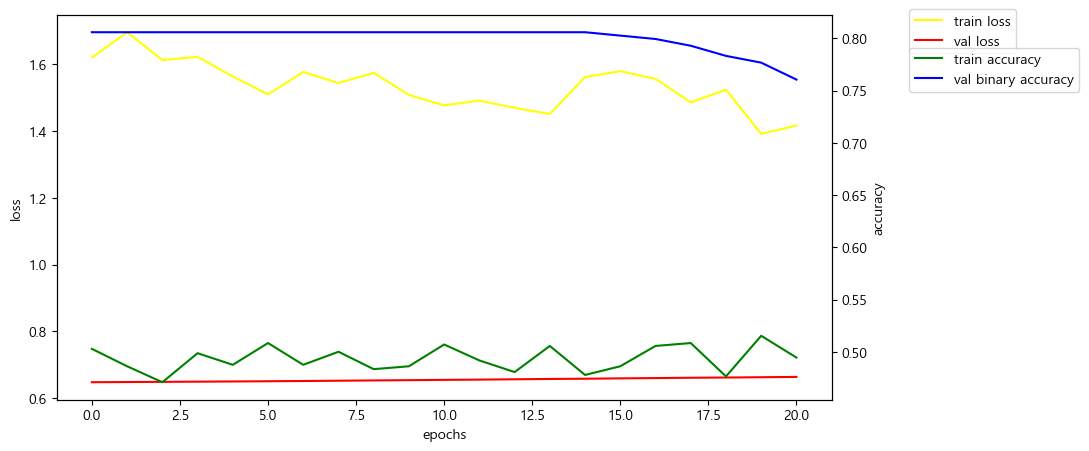

In [20]:
import matplotlib.pyplot as plt

plt.rc('font', family = "Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False

fig, loss_ax = plt.subplots(figsize=(10,5))

loss_ax.plot(history.history.get('loss'), color='yellow',label='train loss')
loss_ax.plot(history.history.get('val_loss'), color='red',label='val loss')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc=(1.1,0.9))
acc_ax = loss_ax.twinx()
acc_ax.plot(history.history.get('accuracy'),color='green',label='train accuracy')
acc_ax.plot(history.history.get('val_accuracy'),color='blue',label='val binary accuracy')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc=(1.1,0.8))

# 모델평가

In [23]:
data = model.evaluate(X_test,Y_test)
data

14/14 [==============================] - 0s 4ms/step - loss: 0.6458 - auc_pr: 0.1452 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.8413


[0.6458147168159485, 0.1452142298221588, 0.0, 0.0, 0.841269850730896]

In [24]:
pred = model.predict(X_test).astype("int")
pd.crosstab(list(Y_test), pred.ravel(), rownames=['실제값'],colnames=['예측값'])

14/14 [==============================] - 0s 2ms/step


예측값,0
실제값,
0,373
1,68


# accuracy는 잘 나오지만 결국 데이터 불균형 때문인지 딥러닝 모델에서는 1(좋음) 평가에 대한 분류가 절대 불가